# Task-I

This notebook contains the code to classify images into three categories based on their lensing features:

1. Strong lensing images without substructure.
2. Subhalo substructure.
3. Vortex substructure.

The task involves preparing the dataset for training a deep learning model and establishing an initial model architecture.
In our study Efficientnet Performs better than other models.

In [2]:
import os 
os.chdir('/kaggle/input/image-classifier')

In [3]:
# Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import os 
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Visualization

In [5]:
image_no = np.load('dataset/val/no/1.npy')
image_sphere = np.load('dataset/val/sphere/1.npy')
image_vortex = np.load('dataset/val/vort/1.npy')
print(image_no.shape)
print(image_sphere.shape)
print(image_vortex.shape)

(1, 150, 150)
(1, 150, 150)
(1, 150, 150)


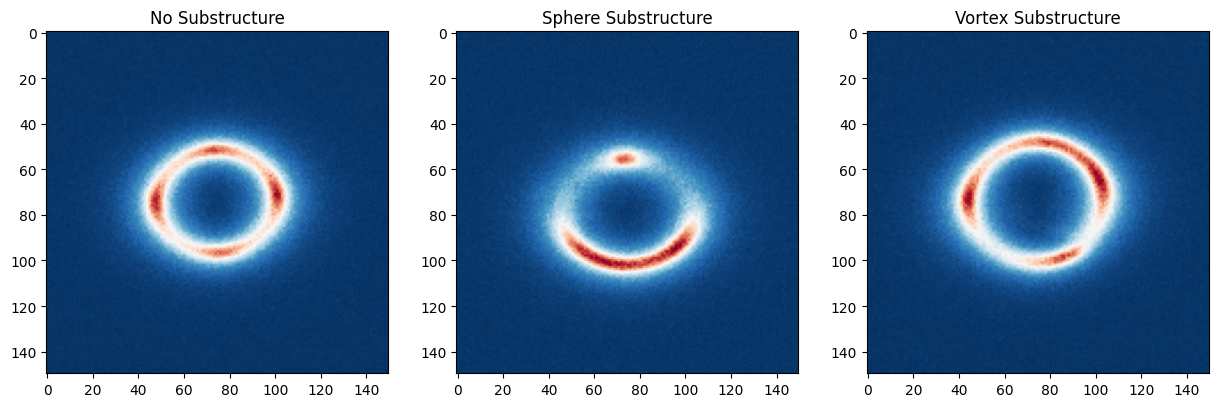

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(image_no[0], cmap='RdBu_r')
ax[0].set_title('No Substructure')
ax[1].imshow(image_sphere[0], cmap='RdBu_r')
ax[1].set_title('Sphere Substructure')
ax[2].imshow(image_vortex[0], cmap='RdBu_r')
ax[2].set_title('Vortex Substructure')

plt.show()


In [7]:
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import glob

class GravitationalLensImage(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.images, self.labels = self._load_images_and_labels()

    def _load_images_and_labels(self):
        images, labels = [], []
        for label, cls in enumerate(self.classes):
            files = glob.glob(os.path.join(self.main_dir, cls, '*.npy'))
            for file_path in files:
                images.append(np.load(file_path))
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] 
        
        if self.transform:
            image = np.squeeze(image)
            image = np.clip(image * 255.0, 0, 255).astype(np.uint8)
            image = Image.fromarray(image)
            image = self.transform(image)
        return image, label

In [8]:
from torchvision.transforms import InterpolationMode
from torch.utils.data import random_split
from torchvision.transforms import transforms 

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dir_dataset = GravitationalLensImage(main_dir='dataset/train', transform=transform)
test_dataset = GravitationalLensImage(main_dir='dataset/val', transform=transform)


num_images = len(train_dir_dataset)
print(num_images)

# number of images for training (90%) and testing (10%)
train_size = int(num_images * 0.9)
val_size = num_images - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dir_dataset, [train_size, val_size])

30000


In [9]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
print(len(train_loader))

211


In [11]:
for i, data in enumerate(train_loader, 0):
    print(data[0].shape)
    break

torch.Size([128, 1, 150, 150])


We will use Efficient Net to build this Image classifier 

Efficient Net 

In [21]:
import torch
from torch import nn
from torchvision.models import efficientnet_b1
from torchvision import models

class EfficientNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(EfficientNet, self).__init__()
        self.in_channel = in_channel
        self.num_classes = num_classes
        
        self.effnet = efficientnet_b1(weights ='DEFAULT')
    
        self.effnet.features[0][0] = nn.Conv2d(self.in_channel, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        num_ftrs = self.effnet.classifier[1].in_features
        self.effnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 100),
        )
        
        self.lin1 = nn.Linear(100, self.num_classes)
    
    def forward(self, x):
        x = self.effnet(x)
        x = self.lin1(x)
        return x


In [12]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def train_model(model, criterion, optimizer, train_loader, Val_loader, num_epochs, device, scheduler=None):
    model.to(device)
    losses = []  # Store the loss at each epoch

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()  # Ensure model is in "training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Transfer inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        # Update the learning rate if a scheduler is provided
        if scheduler is not None:
            scheduler.step()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)  # Store the loss

        # Print loss at the end of each epoch
        print(f'Epoch {epoch + 1} completed, Loss: {epoch_loss:.6f}')
        
        # Validation after every 5 epochs
        if (epoch + 1) % 5 == 0:
            correct = 0
            total = 0
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                for inputs, labels in Val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print(f'Validation Accuracy after epoch {epoch + 1}: {100 * correct / total:.2f}%')
        
        running_loss = 0.0

    print('Finished Training')

    # Plot the loss vs epoch
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.show()

In [13]:
import torch

def test_model(model, test_loader, device):
    # Ensure model is in evaluation mode
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad(): # No need to track gradients
        for images, labels in test_loader:
            # Move images and labels to the designated device (GPU or CPU)
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass to get outputs
            outputs = model(images)
            
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}%')
    return accuracy


In [14]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

def compute_roc_auc(model, test_loader, device):
    # Define class labels directly within the function
    class_labels = ['no', 'sphere', 'vort']
    num_classes = len(class_labels)

    model.eval()
    model.to(device)
    
    y_pred = []
    y_true = []
    
    # Collect all labels and predictions
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            y_pred.append(probabilities)
            y_true.append(labels.cpu().numpy())

    # Convert the lists to a numpy array
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    
    # Binarize the true labels in a one-vs-all fashion
    y_true_binary = label_binarize(y_true, classes=range(num_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(class_labels[i], roc_auc[i]))
    
    # Plot the diagonal line for random chance
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [15]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_confusion_matrix(model, test_loader, device, num_classes):
    # Define class labels
    class_labels = ['no', 'sphere', 'vort']
    
    model.eval()
    model.to(device)
    
    y_pred = []
    y_true = []
    
    # Gather the true labels and predictions from the model
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Compute the confusion matrix using sklearn's confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [26]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model_efficientnet = EfficientNet(in_channel=1, num_classes=3)
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model_efficientnet)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), 0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

Let's use 2 GPUs!


Epoch 1 completed, Loss: 1.101112
Epoch 2 completed, Loss: 0.938073
Epoch 3 completed, Loss: 0.581221
Epoch 4 completed, Loss: 0.396460
Epoch 5 completed, Loss: 0.304063
Validation Accuracy after epoch 5: 86.77%
Epoch 6 completed, Loss: 0.254723
Epoch 7 completed, Loss: 0.219876
Epoch 8 completed, Loss: 0.191472
Epoch 9 completed, Loss: 0.162444
Epoch 10 completed, Loss: 0.150737
Validation Accuracy after epoch 10: 89.37%
Epoch 11 completed, Loss: 0.133962
Epoch 12 completed, Loss: 0.123721
Epoch 13 completed, Loss: 0.106355
Epoch 14 completed, Loss: 0.097180
Epoch 15 completed, Loss: 0.086790
Validation Accuracy after epoch 15: 90.17%
Epoch 16 completed, Loss: 0.080476
Epoch 17 completed, Loss: 0.070122
Epoch 18 completed, Loss: 0.069747
Epoch 19 completed, Loss: 0.061418
Epoch 20 completed, Loss: 0.054573
Validation Accuracy after epoch 20: 91.53%
Epoch 21 completed, Loss: 0.053127
Epoch 22 completed, Loss: 0.052610
Epoch 23 completed, Loss: 0.047287
Epoch 24 completed, Loss: 0.04472

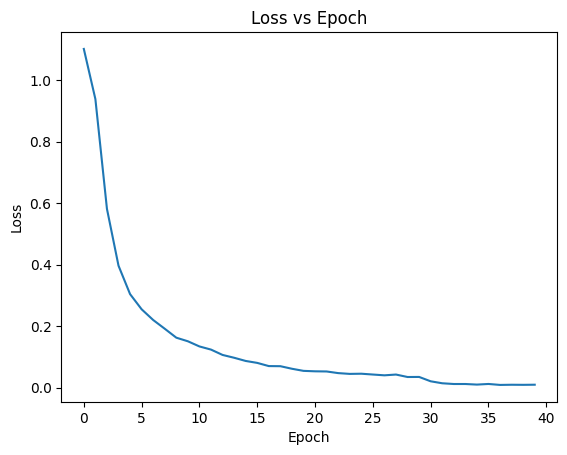

In [20]:
train_model(model=model_efficientnet, criterion=criterion, optimizer=optimizer, train_loader=train_loader, Val_loader=val_loader, num_epochs=40, device=device, scheduler=scheduler)

In [22]:
torch.save(model_efficientnet.state_dict(), '/kaggle/working/model_effnet.pth')

In [27]:
model_efficientnet.load_state_dict(torch.load('/kaggle/working/model_effnet.pth', map_location=device))

<All keys matched successfully>

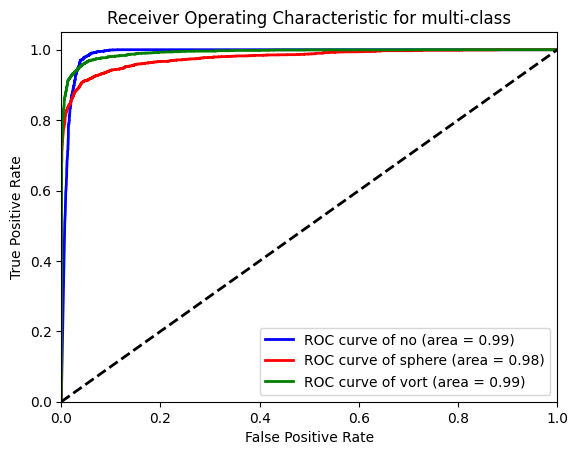

Area Under curve for different classes is :{0: 0.9889605599999999, 1: 0.97724924, 2: 0.99205888}


In [33]:
roc_effnet = compute_roc_auc(model_efficientnet, test_loader, device)
print(f'Area Under curve for different classes is :{roc_effnet}')

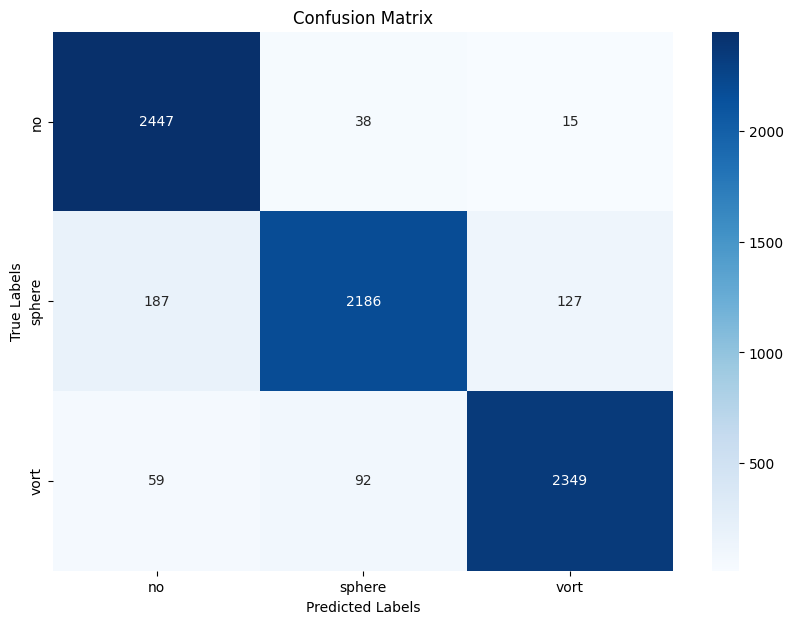

In [39]:
compute_confusion_matrix(model_efficientnet, test_loader, device, 3)

In [40]:
test_Acc = test_model(model_efficientnet, test_loader, device)

Accuracy of the network on the test images: 93.09333333333333%


In [12]:
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim

class ResNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(ResNet, self).__init__()
        self.in_channel = in_channel
        self.num_classes = num_classes
        
        # Load a pre-trained ResNet50 model
        self.resnet = resnet50(weights='DEFAULT')
        
        # Modify the first convolutional layer to have the specified number of input channels
        self.resnet.conv1 = nn.Conv2d(self.in_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes),
        )
    
    def forward(self, x):
        x = self.resnet(x)
        return x

In [27]:
model_resnet = ResNet(1, 3)
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model_resnet = torch.nn.DataParallel(model_resnet)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), 0.0001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

Let's use 2 GPUs!


Epoch 1 completed, Loss: 1.099442
Epoch 2 completed, Loss: 1.083487
Epoch 3 completed, Loss: 1.011882
Epoch 4 completed, Loss: 0.876695
Epoch 5 completed, Loss: 0.730566
Validation Accuracy after epoch 5: 57.20%
Epoch 6 completed, Loss: 0.592493
Epoch 7 completed, Loss: 0.457699
Epoch 8 completed, Loss: 0.339021
Epoch 9 completed, Loss: 0.250643
Epoch 10 completed, Loss: 0.177433
Validation Accuracy after epoch 10: 68.20%
Epoch 11 completed, Loss: 0.133609
Epoch 12 completed, Loss: 0.103412
Epoch 13 completed, Loss: 0.086753
Epoch 14 completed, Loss: 0.074025
Epoch 15 completed, Loss: 0.059976
Validation Accuracy after epoch 15: 68.20%
Epoch 16 completed, Loss: 0.054130
Epoch 17 completed, Loss: 0.052958
Epoch 18 completed, Loss: 0.050254
Epoch 19 completed, Loss: 0.043383
Epoch 20 completed, Loss: 0.046156
Validation Accuracy after epoch 20: 70.27%
Epoch 21 completed, Loss: 0.036539
Epoch 22 completed, Loss: 0.038049
Epoch 23 completed, Loss: 0.036544
Epoch 24 completed, Loss: 0.04397

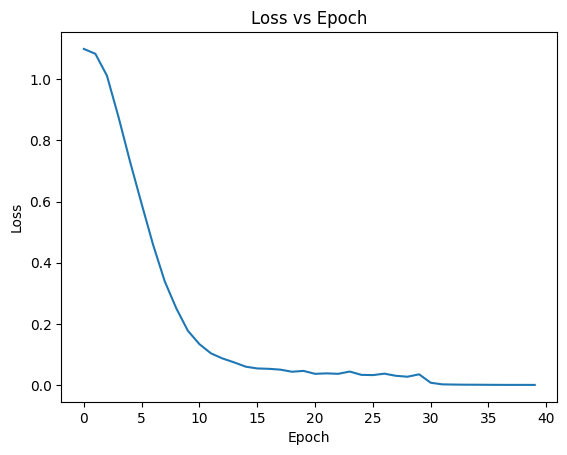

In [28]:
train_model(model=model_resnet, criterion=criterion, optimizer=optimizer, train_loader=train_loader, Val_loader=val_loader, num_epochs=40, device=device, scheduler=scheduler)

In [30]:
torch.save(model_resnet.state_dict(), '/kaggle/working/model_resnet.pth')

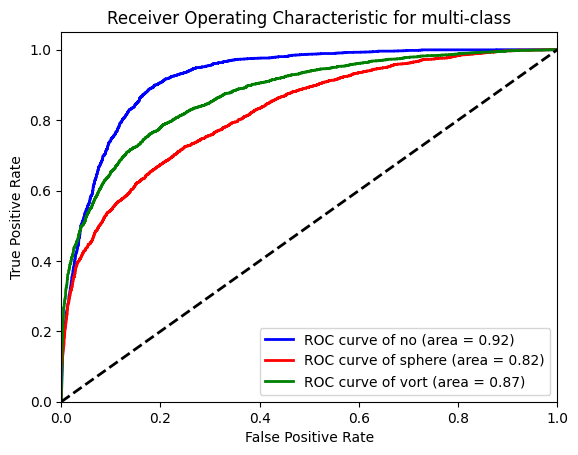

Area Under curve for different classes is :{0: 0.92178176, 1: 0.8229214399999999, 2: 0.8738085999999999}


In [31]:
roc_resnet = compute_roc_auc(model_resnet, test_loader, device)
print(f'Area Under curve for different classes is :{roc_resnet}')

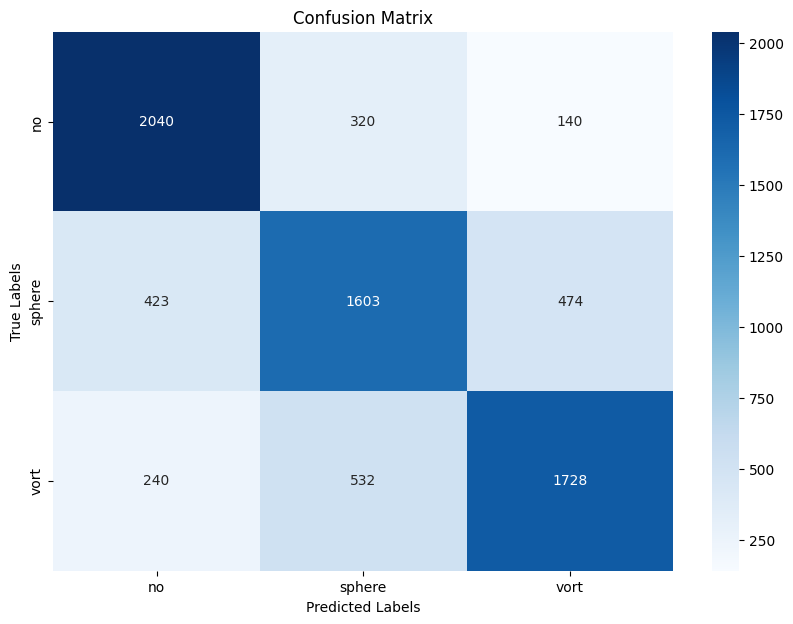

In [32]:
compute_confusion_matrix(model_resnet, test_loader, device, 3)

In [34]:
test_Acc = test_model(model_resnet, test_loader, device)

Accuracy of the network on the test images: 71.61333333333333%


In [20]:
from torchvision.models import densenet121

class DenseNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = densenet121(weights='DEFAULT')
        self.densenet.features[0] = nn.Conv2d(in_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.densenet(x)
        return x


In [23]:
model_dense = DenseNet(1, 3)
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model_dense = torch.nn.DataParallel(model_dense)
criterion_dense = nn.CrossEntropyLoss()
optimizer_dense = optim.Adam(model_dense.parameters(), 0.0001)
scheduler_dense = StepLR(optimizer_dense, step_size=30, gamma=0.1)

Let's use 2 GPUs!


Epoch 1 completed, Loss: 1.105573
Epoch 2 completed, Loss: 1.001668
Epoch 3 completed, Loss: 0.852959
Epoch 4 completed, Loss: 0.694678
Epoch 5 completed, Loss: 0.535146
Validation Accuracy after epoch 5: 69.73%
Epoch 6 completed, Loss: 0.410248
Epoch 7 completed, Loss: 0.315550
Epoch 8 completed, Loss: 0.243153
Epoch 9 completed, Loss: 0.190663
Epoch 10 completed, Loss: 0.143869
Validation Accuracy after epoch 10: 77.80%
Epoch 11 completed, Loss: 0.113191
Epoch 12 completed, Loss: 0.098642
Epoch 13 completed, Loss: 0.073530
Epoch 14 completed, Loss: 0.056705
Epoch 15 completed, Loss: 0.055551
Validation Accuracy after epoch 15: 80.73%
Epoch 16 completed, Loss: 0.049849
Epoch 17 completed, Loss: 0.046999
Epoch 18 completed, Loss: 0.041224
Epoch 19 completed, Loss: 0.037570
Epoch 20 completed, Loss: 0.033914
Validation Accuracy after epoch 20: 82.27%
Epoch 21 completed, Loss: 0.036348
Epoch 22 completed, Loss: 0.032694
Epoch 23 completed, Loss: 0.026916
Epoch 24 completed, Loss: 0.03516

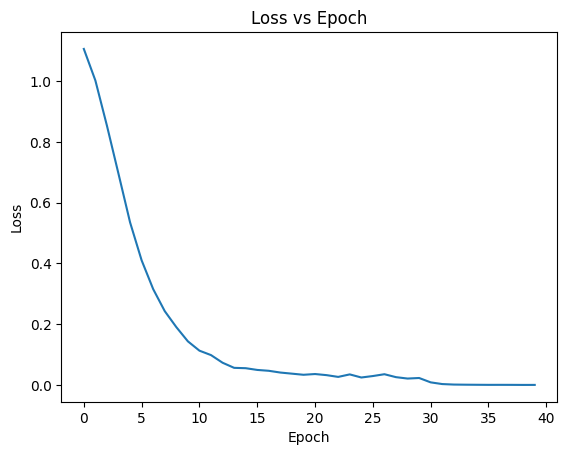

In [24]:
train_model(model=model_dense, criterion=criterion_dense, optimizer=optimizer_dense, train_loader=train_loader, Val_loader=val_loader, num_epochs=40, device=device, scheduler=scheduler_dense)

In [25]:
torch.save(model_dense.state_dict(), '/kaggle/working/model_dense.pth')

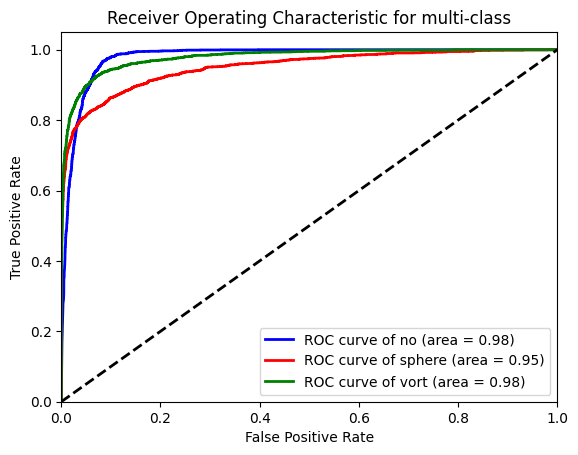

Area Under curve for different classes is :{0: 0.9787764800000001, 1: 0.9499049600000001, 2: 0.97770544}


In [26]:
roc_dense = compute_roc_auc(model_dense, test_loader, device)
print(f'Area Under curve for different classes is :{roc_dense}')

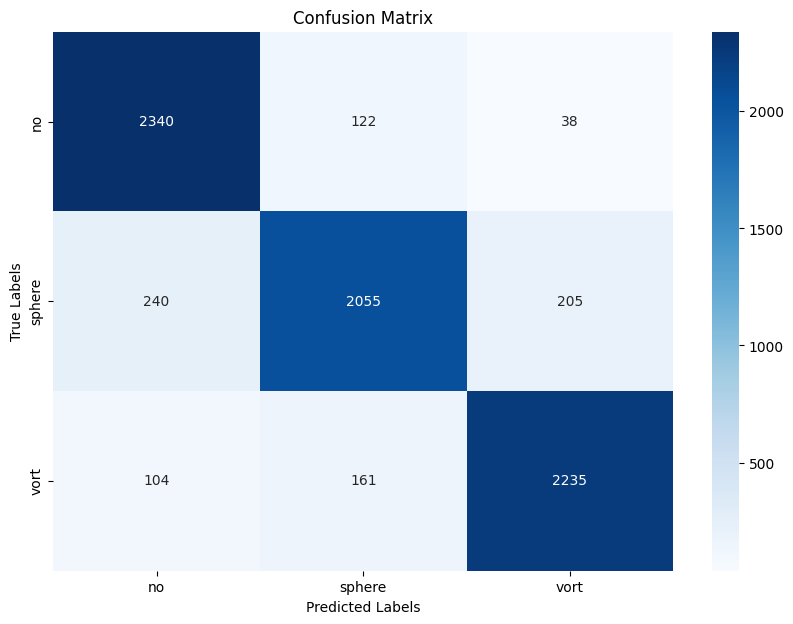

In [27]:
compute_confusion_matrix(model_dense, test_loader, device, 3)

In [28]:
test_Acc = test_model(model_dense, test_loader, device)

Accuracy of the network on the test images: 88.4%


In [29]:
from torchvision.models import alexnet

class AlexNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(AlexNet, self).__init__()
        self.alexnet = alexnet(weights='DEFAULT')
        self.alexnet.features[0] = nn.Conv2d(in_channel, 64, kernel_size=11, stride=4, padding=2)
        
        num_ftrs = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.alexnet(x)
        return x